In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import norm
import requests
from io import StringIO
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
import lseg.data as ld
ld.open_session()


<lseg.data.session.Definition object at 0x260f819f590 {name='workspace'}>

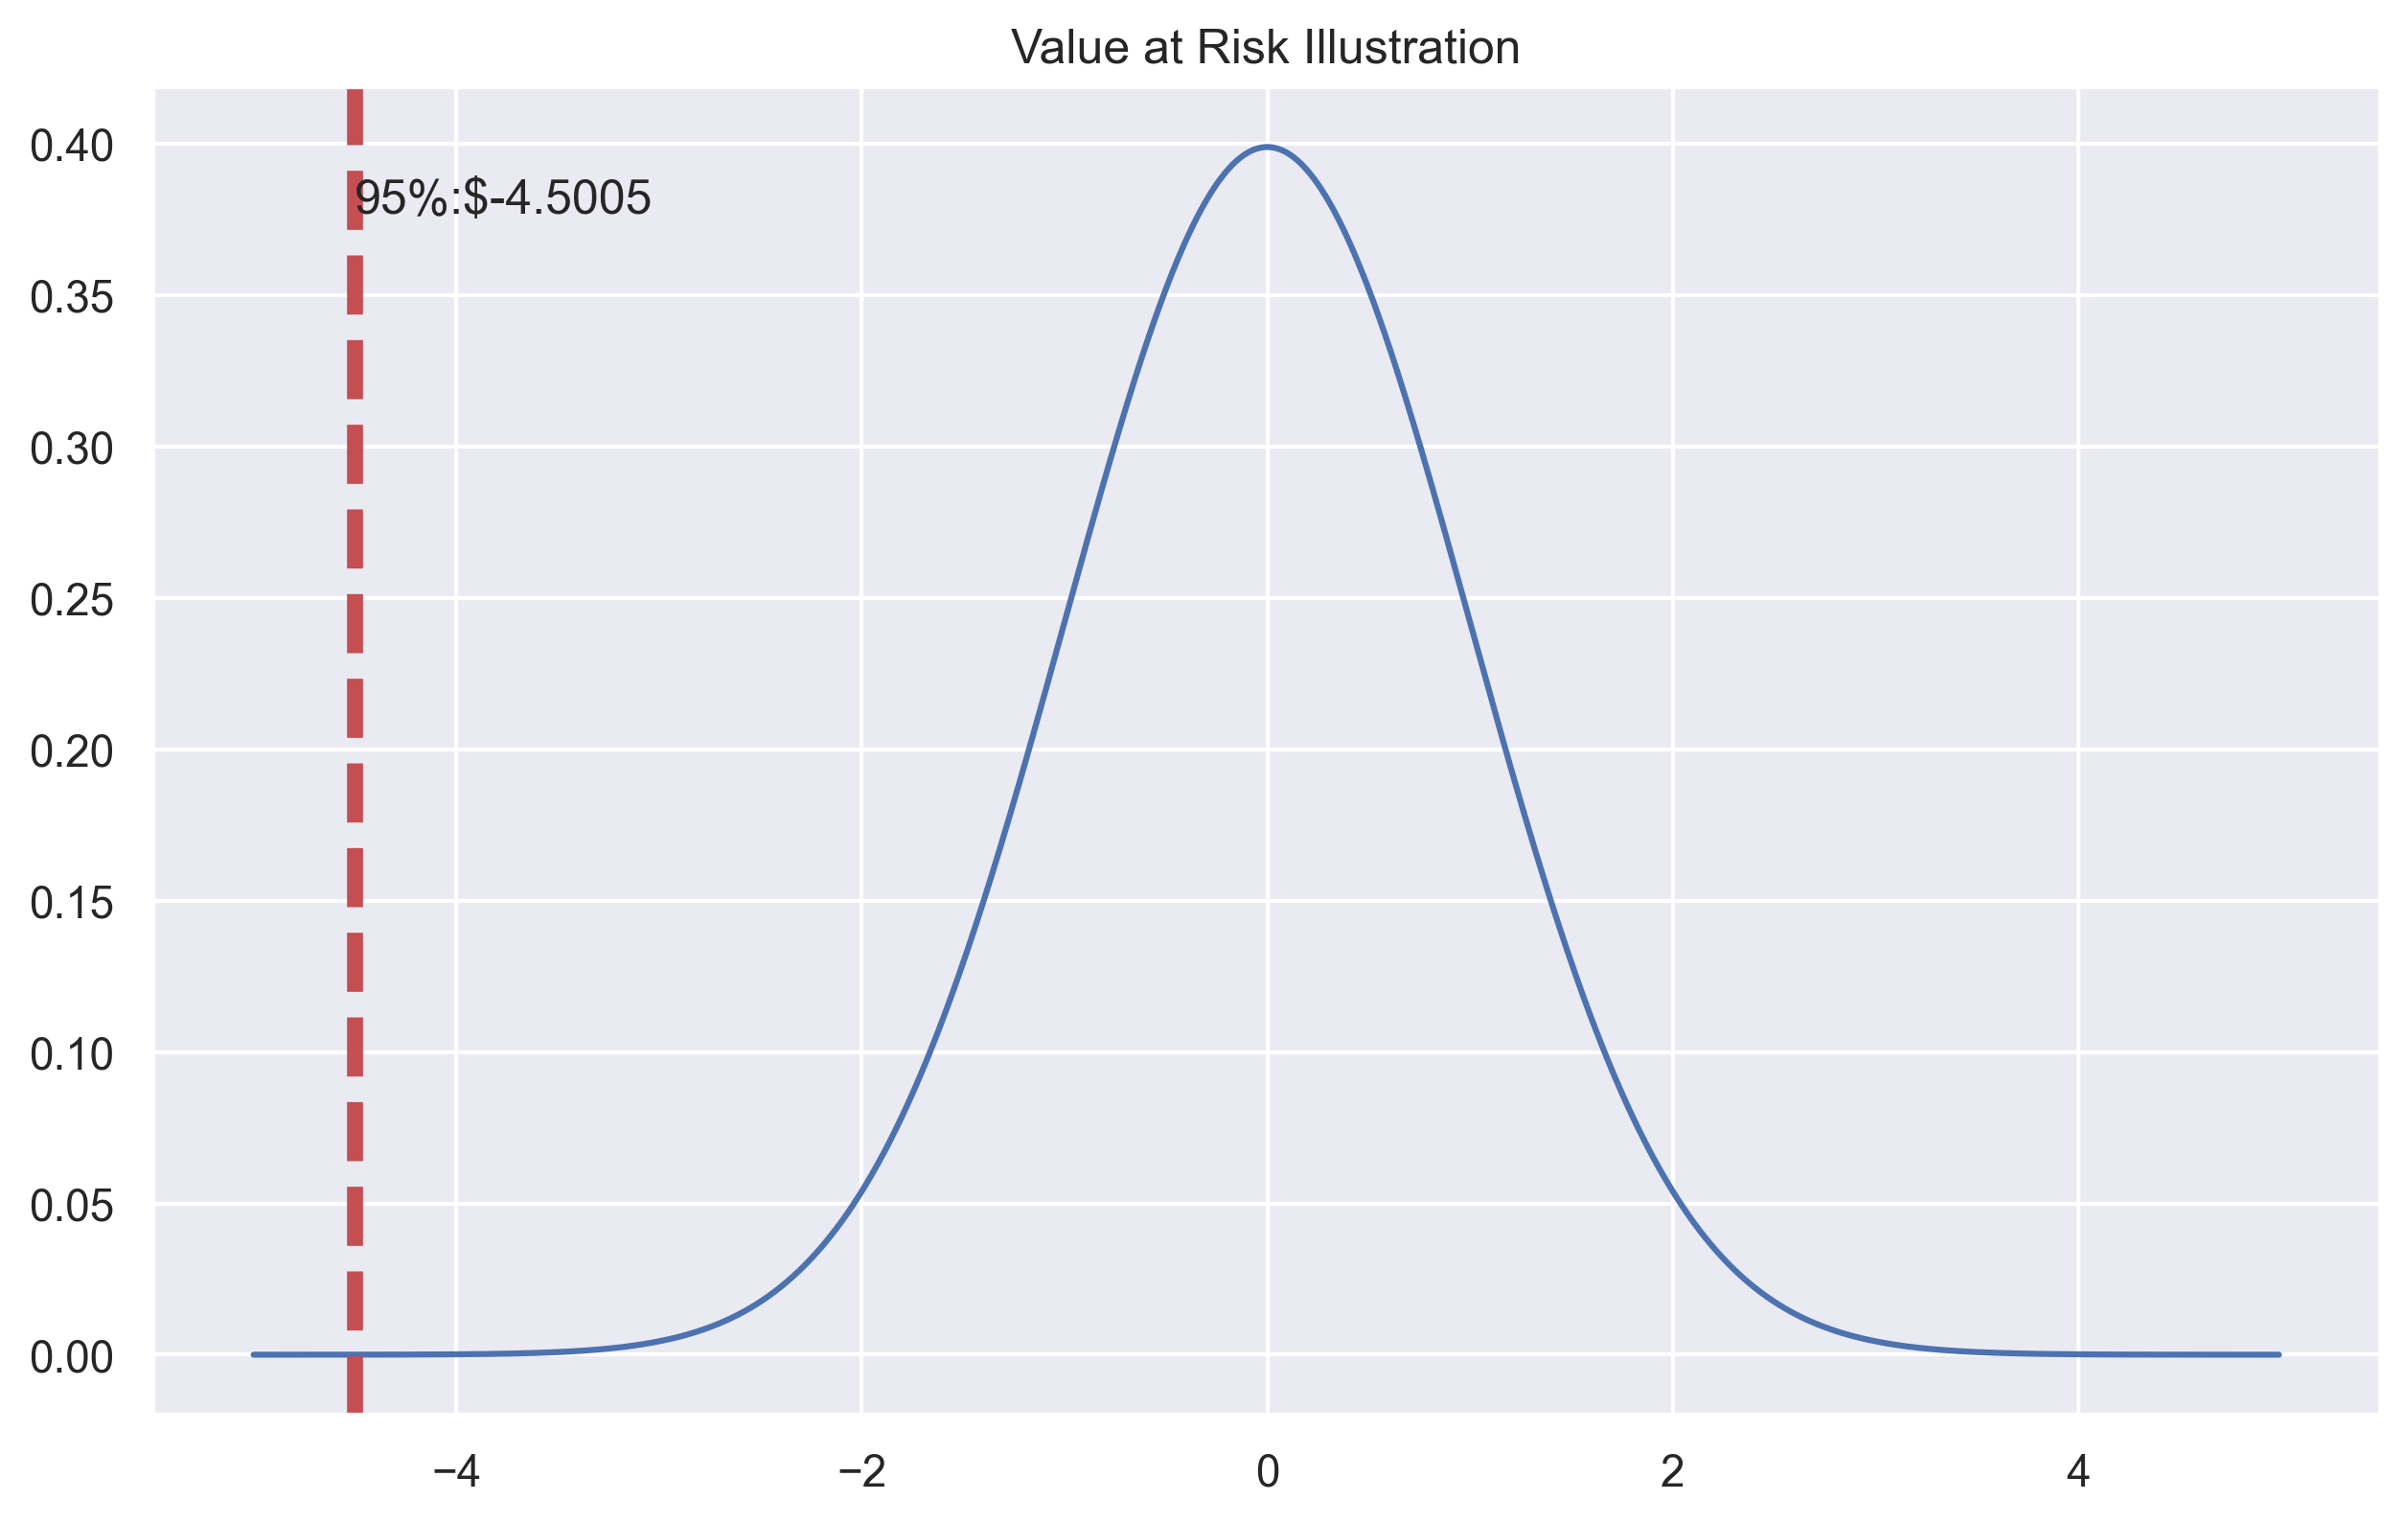

In [3]:
mean = 0
std_dev = 1
x = np.arange(-5, 5, 0.01)
y = norm.pdf(x, mean, std_dev)
pdf = plt.plot(x, y)
min_ylim, max_ylim = plt.ylim()
plt.text(np.percentile(x, 5), max_ylim * 0.9, '95%:${:.4f}'
         .format(np.percentile(x, 5)))
plt.axvline(np.percentile(x, 5), color='r', linestyle='dashed',
            linewidth=4)
plt.title('Value at Risk Illustration')
plt.show()

In [4]:
RICS = ["VLO", "JPM", "LMT"]
ts = ld.get_data(RICS,
                   [
                    'TR.PriceClose(SDate=2021-01-02,EDate=2025-10-01,Frq=D).date',
                    'TR.PriceClose(SDate=2021-01-02,EDate=2025-01-01,Frq=D)'
                   ])
ts2 = ts.drop_duplicates()
ts2

,Instrument,Date,Price Close
0,VLO,2021-01-04,55.73
1,VLO,2021-01-05,57.32
2,VLO,2021-01-06,58.6
3,VLO,2021-01-07,59.67
4,VLO,2021-01-08,57.71
...,...,...,...
3571,LMT,2025-09-25,<NA>
3572,LMT,2025-09-26,<NA>
3573,LMT,2025-09-29,<NA>
3574,LMT,2025-09-30,<NA>


In [5]:
stocks = ts2.pivot(index="Date", columns="Instrument", values="Price Close")
stocks

Instrument,JPM,LMT,VLO
Date,,,
2021-01-04,125.87,344.64,55.73
2021-01-05,125.65,348.79,57.32
2021-01-06,131.55,348.03,58.6
2021-01-07,135.87,342.55,59.67
2021-01-08,136.02,336.1,57.71
...,...,...,...
2025-09-25,<NA>,<NA>,<NA>
2025-09-26,<NA>,<NA>,<NA>
2025-09-29,<NA>,<NA>,<NA>


In [6]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()
stocks_returns

Instrument,JPM,LMT,VLO
Date,,,
2021-01-05,-0.001749,0.01197,0.028131
2021-01-06,0.045887,-0.002181,0.022085
2021-01-07,0.032312,-0.015871,0.018095
2021-01-08,0.001103,-0.019009,-0.033399
2021-01-11,0.014814,0.00469,0.015987
...,...,...,...
2024-12-24,0.01631,0.003365,0.0016
2024-12-26,0.00342,0.003783,0.007043
2024-12-27,-0.008135,-0.002063,-0.000836


In [7]:
stocks_returns_mean = stocks_returns.mean()
weights  = np.random.random(len(stocks_returns.columns))
weights /= np.sum(weights)
#weights =  np.array([.333, .333, .333], dtype='float')
cov_var = stocks_returns.cov()
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [8]:
weights

array([0.13575855, 0.41263525, 0.45160619])

In [9]:
stocks_returns_mean

Instrument
JPM    0.000642
LMT    0.000342
VLO    0.000785
dtype: Float64

In [10]:
print(stocks_returns_mean)
print(weights)
print(cov_var)
print(port_std) 

Instrument
JPM    0.000642
LMT    0.000342
VLO    0.000785
dtype: Float64
[0.13575855 0.41263525 0.45160619]
Instrument       JPM       LMT       VLO
Instrument                              
JPM         0.000231  0.000036  0.000125
LMT         0.000036  0.000170  0.000062
VLO         0.000125  0.000062  0.000535
0.013601534588111192


In [11]:
weights = np.array([.2,.3,.4])

In [12]:
stocks_returns_mean = stocks_returns.mean()
stocks_returns_mean

Instrument
JPM    0.000642
LMT    0.000342
VLO    0.000785
dtype: Float64

In [13]:
initial_investment = 1000000
conf_level = 0.95

In [14]:
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [15]:
port_std

np.float64(0.01222612106986748)

In [16]:
alpha = norm.ppf(.05, stocks_returns_mean, port_std)

In [17]:
alpha

array([-0.01946857, -0.01976796, -0.01932499])

In [18]:
stocks.columns

Index(['JPM', 'LMT', 'VLO'], dtype='string', name='Instrument')

## Variance-Covariance Method

In [19]:
for i, j in zip(stocks.columns, range(len(stocks.columns))):
    VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
    print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))

Parametric VaR result for JPM is 19468.565809341264 
Parametric VaR result for LMT is 19767.963683406007 
Parametric VaR result for VLO is 19324.993477226235 


In [20]:
def VaR_parametric(initial_investment, conf_level):
    alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
        print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))
    VaR_param = (initial_investment - initial_investment * (1 + alpha))
    print('--' * 25)
    return VaR_param

In [21]:
VaR_param = VaR_parametric(initial_investment, conf_level)
VaR_param

Parametric VaR result for JPM is 19468.565809341264 
Parametric VaR result for LMT is 19767.963683406007 
Parametric VaR result for VLO is 19324.993477226235 
--------------------------------------------------


array([19468.56580934, 19767.96368341, 19324.99347723])

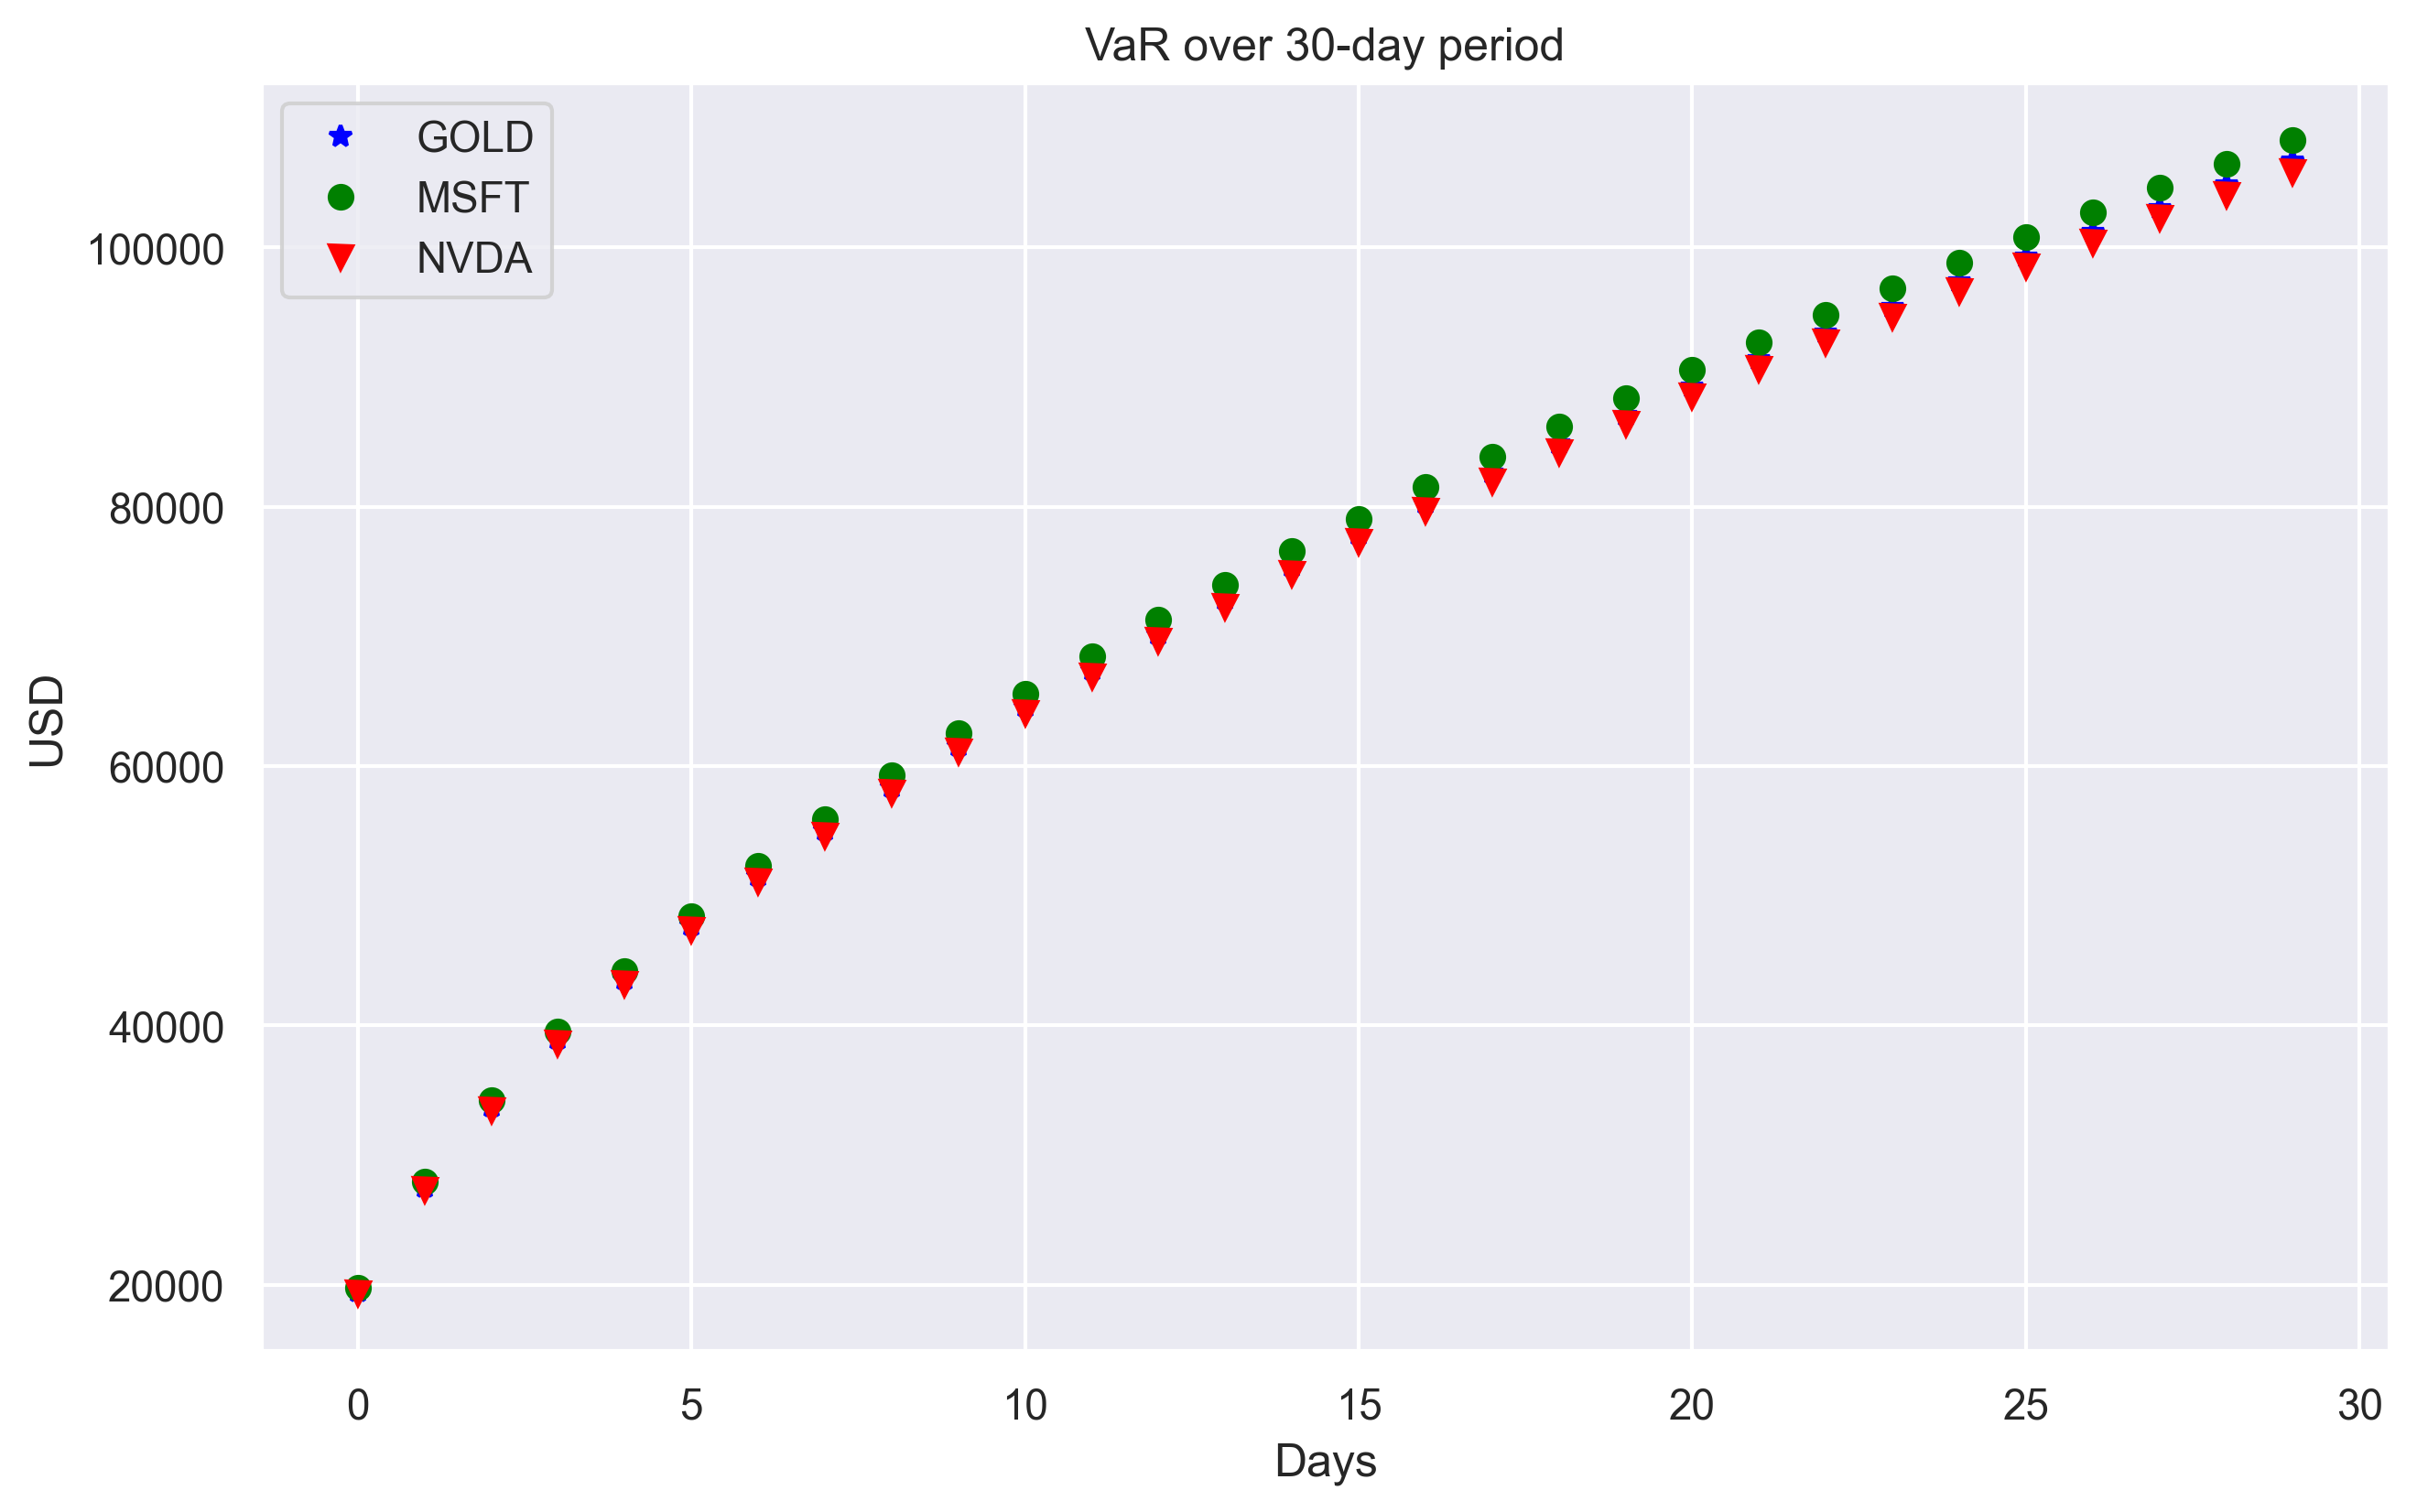

In [22]:
var_horizon = []
time_horizon = 30
for j in range(len(stocks_returns.columns)):
    for i in range(1, time_horizon + 1):
        var_horizon.append(VaR_param[j] * np.sqrt(i))
plt.plot(var_horizon[:time_horizon], "o",
         c='blue', marker='*', label='GOLD')
plt.plot(var_horizon[time_horizon:time_horizon + 30], "o",
         c='green', marker='o', label='MSFT')
plt.plot(var_horizon[time_horizon + 30:time_horizon + 60], "o",
         c='red', marker='v', label='NVDA')
plt.xlabel("Days")
plt.ylabel("USD")
plt.title("VaR over 30-day period")
plt.legend()
plt.show()

## Historical


In [23]:
for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
    print(np.percentile(stocks_returns.loc[:, i], 5))

-0.023977277942903538
-0.01857213456391138
-0.03714489916998728


In [25]:
stocks_returns.loc[:, 'VLO']

Date
2021-01-05    0.028131
2021-01-06    0.022085
2021-01-07    0.018095
2021-01-08   -0.033399
2021-01-11    0.015987
                ...   
2024-12-24      0.0016
2024-12-26    0.007043
2024-12-27   -0.000836
2024-12-30    0.000084
2024-12-31    0.024776
Name: VLO, Length: 1004, dtype: Float64

In [26]:
np.percentile(stocks_returns.loc[:, 'VLO'], 5)

np.float64(-0.03714489916998728)

In [27]:
def VaR_historical(initial_investment, conf_level):
    Hist_percentile95 = []
    for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
        Hist_percentile95.append(np.percentile(stocks_returns.loc[:, i],
                                               5))
        print("Based on historical values 95% of {}'s return is {:.4f}"
              .format(i, Hist_percentile95[j]))
        VaR_historical = (initial_investment - initial_investment *
                          (1 + Hist_percentile95[j]))
        print("Historical VaR result for {} is {:.2f} "
              .format(i, VaR_historical))
        print('--' * 35)

In [28]:
VaR_historical(initial_investment,conf_level)

Based on historical values 95% of JPM's return is -0.0240
Historical VaR result for JPM is 23977.28 
----------------------------------------------------------------------
Based on historical values 95% of LMT's return is -0.0186
Historical VaR result for LMT is 18572.13 
----------------------------------------------------------------------
Based on historical values 95% of VLO's return is -0.0371
Historical VaR result for VLO is 37144.90 
----------------------------------------------------------------------


## Monte Carlo VaR

In [29]:
x = np.random.uniform(-1, 1, 100) 
y = np.random.uniform(-1, 1, 100)

In [30]:
y

array([-0.15496505,  0.86650048, -0.25058414,  0.96126742, -0.8636895 ,
       -0.30321405,  0.79591093,  0.62366914, -0.27152867, -0.60204805,
        0.56419886, -0.76750209,  0.87382741,  0.26062434, -0.52045591,
        0.97865159, -0.17065557,  0.02588034, -0.29730866,  0.71928162,
       -0.44857215,  0.41284277, -0.47715008,  0.20214952, -0.85608022,
       -0.79093615, -0.81559262,  0.78341564, -0.87409038, -0.40463831,
        0.29199045,  0.38194978,  0.94075554,  0.16803203,  0.66798427,
        0.24458028, -0.26667956,  0.75490215, -0.5699186 ,  0.25863686,
       -0.24045045, -0.27351039, -0.37365592,  0.47136354,  0.86269356,
        0.76978191, -0.53138132, -0.38890502,  0.98326309, -0.16180441,
       -0.85042097, -0.05218506, -0.37754856, -0.7725667 ,  0.30576122,
        0.74050409, -0.68422677, -0.69931551,  0.4516762 , -0.93116674,
       -0.91013143,  0.30570367, -0.77698763,  0.03084478,  0.87289021,
        0.16994932,  0.19939585, -0.59982384, -0.81484559,  0.33

In [31]:
x

array([-0.10822064,  0.80831422,  0.58481934,  0.10569632,  0.88986925,
       -0.81211242,  0.53827962, -0.48938564,  0.51674074,  0.95447904,
        0.36046655, -0.76865924, -0.24932857,  0.21827565, -0.1125683 ,
       -0.77575518,  0.17897499,  0.14403904, -0.99150514,  0.23574455,
        0.81932558, -0.33614604, -0.34264719, -0.49285343,  0.11437388,
       -0.28020795,  0.88257764, -0.70749685,  0.07929214,  0.84273596,
       -0.50733805,  0.36326505,  0.68102665, -0.22261287,  0.29671864,
        0.21671962, -0.81794327,  0.63321811,  0.39321953,  0.22440183,
        0.18750805, -0.23809566,  0.29251548,  0.73334776, -0.92921281,
       -0.97106366, -0.30480244, -0.1251661 ,  0.02335901,  0.30090024,
       -0.36616944, -0.10042784, -0.71586761, -0.71351209,  0.04334858,
       -0.7053233 ,  0.66346014,  0.52792347,  0.76937773, -0.48771312,
        0.77058943,  0.74308319,  0.03732086,  0.64974135, -0.64653794,
       -0.45325464, -0.47538301,  0.30108019, -0.2528269 , -0.63

In [32]:
sample = 100    
def pi_calc(x, y):
    point_inside_circle = 0
    for i in range(sample):
        if np.sqrt(x[i] ** 2 + y[i] ** 2) <= 1:
            point_inside_circle += 1 
    print('pi value is {}'.format(4 * point_inside_circle/sample))

In [ ]:
pi_calc(x,y)

pi value is 3.04


In [34]:
len(stocks.columns)

3

In [35]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    print(i)

0
1
2


In [36]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    mean = np.random.randn(n).mean()
    std = np.random.randn(n).std()
    temp = pd.DataFrame(np.random.normal(mean, std, num_reps))
    sim_data = pd.concat([sim_data, temp], axis=1)
sim_data.columns = ['Simulation 1', 'Simulation 2', 'Simulation 3']

In [37]:
sim_data

,Simulation 1,Simulation 2,Simulation 3
0,-0.764506,1.251566,0.080304
1,-0.721224,0.446958,-0.274985
2,0.593009,0.287648,0.887120
3,0.951280,1.253719,0.295390
4,-1.164276,-0.069249,-0.562566
...,...,...,...
995,0.267906,0.321086,-0.639742
996,1.434745,0.001963,-0.250826
997,-1.043340,1.427960,-0.964514
998,-2.557405,-1.450881,0.505293


In [38]:
MC_percentile95 = []
for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
    print(i,j)

Simulation 1 0
Simulation 2 1
Simulation 3 2


In [39]:
def MC_VaR(initial_investment, conf_level):
    MC_percentile95 = []
    for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
        MC_percentile95.append(np.percentile(sim_data.loc[:, i], 5))
        print("Based on simulation 95% of {}'s return is {:.4f}"
              .format(i, MC_percentile95[j]))
        VaR_MC = (initial_investment - initial_investment * 
                  (1 + MC_percentile95[j]))
        print("Simulation VaR result for {} is {:.2f} "
              .format(i, VaR_MC))
        print('--' * 35)

In [40]:
MC_VaR(initial_investment, conf_level)

Based on simulation 95% of Simulation 1's return is -1.4413
Simulation VaR result for Simulation 1 is 1441260.16 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 2's return is -1.5952
Simulation VaR result for Simulation 2 is 1595185.04 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 3's return is -1.3663
Simulation VaR result for Simulation 3 is 1366277.13 
----------------------------------------------------------------------
